In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os

print("✅ MyDrive folders:", os.listdir('/content/drive/MyDrive'))

# Check inside TB_Project
print("📁 Inside TB_Project:", os.listdir('/content/drive/MyDrive/TB Project'))

# Check inside TB_Project/Raw
print("📁 Inside TB_Project/Raw:", os.listdir('/content/drive/MyDrive/TB Project/Raw'))


✅ MyDrive folders: ['Untitled document (1).gdoc', 'InShot_20200506_200723139.mp4', 'InShot_20200506_203318818.mp4', 'Untitled document.gdoc', 'Human Voice Clustering and Classification – Walkthrough Script.gdoc', 'Colab Notebooks', 'TB Project']
📁 Inside TB_Project: ['Raw', 'notebooks', 'train', 'val', 'test']
📁 Inside TB_Project/Raw: ['Normal', 'Tuberculosis']


In [5]:
import os, shutil, random

# Set your base path
base_path = "/content/drive/MyDrive/TB Project"
raw_path = os.path.join(base_path, "Raw")

def prepare_directory_structure(base_path):
    sets = ['train', 'val', 'test']
    classes = ['Normal', 'Tuberculosis']
    for s in sets:
        for c in classes:
            os.makedirs(os.path.join(base_path, s, c), exist_ok=True)

def split_and_copy_images(category, split_ratio=(0.7, 0.2, 0.1)):
    src_folder = os.path.join(raw_path, category)
    images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)
    total = len(images)
    train_end = int(total * split_ratio[0])
    val_end = int(total * (split_ratio[0] + split_ratio[1]))

    for i, img in enumerate(images):
        src = os.path.join(src_folder, img)
        if i < train_end:
            dst = os.path.join(base_path, 'train', category, img)
        elif i < val_end:
            dst = os.path.join(base_path, 'val', category, img)
        else:
            dst = os.path.join(base_path, 'test', category, img)
        shutil.copy(src, dst)

# Run the functions
prepare_directory_structure(base_path)
split_and_copy_images("Normal")
split_and_copy_images("Tuberculosis")


In [6]:
print("Train Normal:", len(os.listdir(os.path.join(base_path, "train/Normal"))))
print("Train TB:", len(os.listdir(os.path.join(base_path, "train/Tuberculosis"))))
print("Val Normal:", len(os.listdir(os.path.join(base_path, "val/Normal"))))
print("Test TB:", len(os.listdir(os.path.join(base_path, "test/Tuberculosis"))))


Train Normal: 458
Train TB: 2298
Val Normal: 181
Test TB: 492


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define paths
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")
test_dir = os.path.join(base_path, "test")

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 2756 images belonging to 2 classes.
Found 1089 images belonging to 2 classes.
Found 589 images belonging to 2 classes.


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a lower learning rate
model.compile(optimizer=Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Define full model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Show summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class labels from training generator
class_labels = train_generator.classes

# Compute weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(class_labels),
                                     y=class_labels)

# Convert to dict
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(3.0087336244541483), 1: np.float64(0.5996518711923412)}


In [16]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    class_weight=class_weight_dict
)


Epoch 1/4
87/87 ━━━━━━━━━━━━━━━━━━━━ 2594s 29s/step - accuracy: 0.8667 - loss: 0.2044 - val_accuracy: 0.8338 - val_loss: 4.1796
Epoch 2/4
87/87 ━━━━━━━━━━━━━━━━━━━━ 2594s 30s/step - accuracy: 0.9939 - loss: 0.0230 - val_accuracy: 0.8338 - val_loss: 6.4089
Epoch 3/4
87/87 ━━━━━━━━━━━━━━━━━━━━ 2494s 29s/step - accuracy: 0.9939 - loss: 0.0209 - val_accuracy: 0.8338 - val_loss: 6.1488
Epoch 4/4
87/87 ━━━━━━━━━━━━━━━━━━━━ 2457s 28s/step - accuracy: 0.9998 - loss: 0.0024 - val_accuracy: 0.8338 - val_loss: 4.3464


In [17]:
# Get predictions
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).reshape(-1)

# True labels
true_classes = test_generator.classes

19/19 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=['Normal', 'Tuberculosis']))


              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        97
Tuberculosis       0.84      1.00      0.91       492

    accuracy                           0.84       589
   macro avg       0.42      0.50      0.46       589
weighted avg       0.70      0.84      0.76       589



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


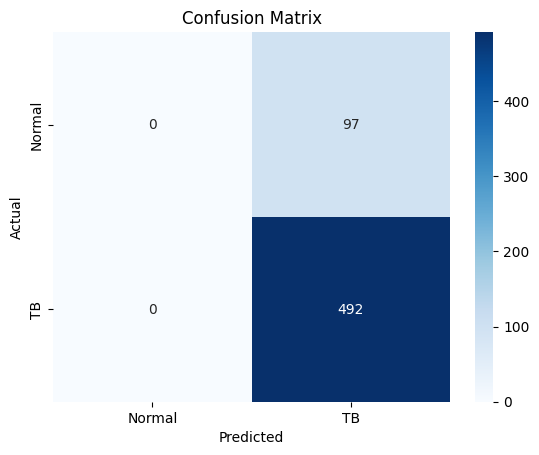

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [24]:
# Get training class labels
class_labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(class_labels),
                                     y=class_labels)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(3.0087336244541483), 1: np.float64(0.5996518711923412)}


In [25]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/TB_Project/mobilenetv2_best_model.h5',
                    save_best_only=True,
                    monitor='val_accuracy')
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5545 - loss: 0.7558

87/87 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.5550 - loss: 0.7551 - val_accuracy: 0.6988 - val_loss: 0.5841
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7477 - loss: 0.5270

87/87 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7480 - loss: 0.5268 - val_accuracy: 0.7612 - val_loss: 0.5000
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8120 - loss: 0.4351

87/87 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8123 - loss: 0.4347 - val_accuracy: 0.8283 - val_loss: 0.4134
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8587 - loss: 0.3504

87/87 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8588 - loss: 0.3502 - val_accuracy: 0.8292 - val_loss: 0.3971
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8972 - loss: 0.2979 - val_accuracy: 0.8228 - val_loss: 0.3882
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8985 - loss: 0.2761

87/87 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.8985 - loss: 0.2760 - val_accuracy: 0.8522 - val_loss: 0.3354
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9144 - loss: 0.2576 - val_accuracy: 0.8466 - val_loss: 0.3344
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.9146 - loss: 0.2274 - val_accuracy: 0.8503 - val_loss: 0.3249
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9354 - loss: 0.1959 - val_accuracy: 0.8466 - val_loss: 0.3254


19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
              precision    recall  f1-score   support

      Normal       0.55      1.00      0.71        97
Tuberculosis       1.00      0.84      0.91       492

    accuracy                           0.87       589
   macro avg       0.78      0.92      0.81       589
weighted avg       0.93      0.87      0.88       589



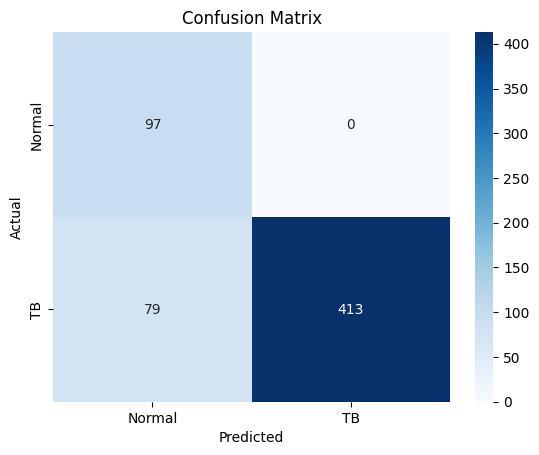

In [27]:
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).reshape(-1)
true_classes = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(true_classes, pred_classes, target_names=['Normal', 'Tuberculosis']))

cm = confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [28]:
model.save("/content/drive/MyDrive/TB_Project/tb_detector_model.h5")